# Magnetic Resonance Imaging 

## Looking Ahead

In the previous example, we verified that an example MR image from a dataset was sparse in the wavelet domain, after we transformed it from the spatial domain. In this example, we will exploit this sparsity in order to recover the MR image from compressive measurements. Recall that MR images are, at acquisition time, obtained in the Fourier domain; this has implications for the measurement map that we construct in a compressed sensing setup. Please review the homework writeup for a discussion of these issues and a justification for the sensing model we implement below.

## Loading the Data

We use the same code from the previous notebook to load in the data. As before, we will focus on a single sagittarial slice of the patient's anatomical data.

In [29]:
## Install AWS CLI tools
!pip install awscli
## Prepare data directory
import os
os.chdir('/content')
!mkdir bold5000
os.chdir('/content/bold5000')

## Grab the data
#!aws s3 sync --no-sign-request --exclude "*" --include "*06*" s3://openneuro.org/ds001499/derivatives/fmriprep/sub-CSI3/ses-13/func/ /content/bold5000/sub-CSI3_ses-13_run-06/
!aws s3 sync --no-sign-request s3://openneuro.org/ds001499/sub-CSI3/ses-16/anat/ /content/bold5000/sub-CSI3_anat/

mkdir: cannot create directory ‘bold5000’: File exists


We add the same auxiliary definitions as last time.

In [0]:
## Auxiliary code for our wavelet experiments
import bokeh
import bokeh.plotting as bpl
from bokeh.models import ColorBar, BasicTicker, LinearColorMapper
import pywt

## Try to do something like imagesc in MATLAB using Bokeh tools.
def imagesc(M, title=''):
  m, n = M.shape
  
  # 600 px should be good; calculate ph to try to get aspect ratio right
  pw = 600
  ph = round(1.0 * pw * m / n)
  h = bpl.figure(plot_width = pw, plot_height = ph, x_range=(0, 1.0*n),
                 y_range=(0, 1.0*m), toolbar_location='below',
                 title=title, match_aspect=True
                )
  
  minval = np.min(M)
  maxval = np.max(M)
  
  color_mapper = LinearColorMapper(palette="Greys256", low=minval, high=maxval)
  h.image(image=[M], x=0, y=0, dw=1.0*n, dh=1.0*m, color_mapper=color_mapper)
  
  color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                      label_standoff=12, border_line_color=None, location=(0, 0))
  
  h.add_layout(color_bar, 'right')
  

  bpl.show(h)
  return h

## Wavelet functions below
## Note: we expect all image sizes to be powers-of-two and square!
## So if you adapt this code, be sure to fix this or enforce this requirement...

# Get a default slice object for a multilevel wavelet transform
# Used to abstract this annoying notation out of the transform...
def default_slices(levels, n):
  c = pywt.wavedec2(np.zeros((n, n)), 'db4', mode='periodization', level=levels)
  bye, slices = pywt.coeffs_to_array(c)
  return slices

# Wrapper for forward discrete wavelet transform
# Output data as a matrix (we don't care about tuple format)
def dwt(levels, sdom_data):
  c = pywt.wavedec2(sdom_data, 'db4', mode='periodization', level=levels)
  output, bye = pywt.coeffs_to_array(c)
  return output

# Wrapper for inverse discrete wavelet transform
# Expect wdom_data as a matrix (we don't care about tuple format)
def idwt(levels, wdom_data, slices=None):
  n = wdom_data.shape[0]
  if slices is None:
    slices = default_slices(levels, n)
  c = pywt.array_to_coeffs(wdom_data, slices, output_format='wavedec2')
  return pywt.waverec2(c, 'db4', mode='periodization')

We finally extract the sagittarial slice we will study. Again, same as last time.

In [31]:
import numpy as np
import nibabel as nib

img = nib.load('/content/bold5000/sub-CSI3_anat/sub-CSI3_ses-16_T1w.nii.gz')

data = img.get_fdata()

## Store dimensions
Nx = data.shape[0]
Ny = data.shape[1]
Nz = data.shape[2]
n = Ny
X = data[Nx//2, :, :];

bpl.output_notebook()
imagesc(data[Nx//2, :, :], title='MR Image We Will Recover')

Figure(id='2903', ...)

## Implementing the Measurement Model

An MR machine collects samples of the 2D Fourier transformation of the underlying spatial profile (e.g., the figure above). An MR machine that employs compressive sensing does the same, but collects far fewer than the `n ** 2` measurements necessary to exactly represent the image at the resolution we are using above. From the lecture, we know that such subsampling leads to an incoherent measurement map when the sampling is done randomly; and we expect thus that L1 minimization will work for recovery from the compressive measurements.

The measurement model we will implement here is the Bernoulli one described in the homework handout. We will implement this below.

In [0]:
## Create the index set for our mapping
p = 0.6   # bernoulli distribution parameter
Omega = {}# We define Omega here to contain all the indices to _delete_
for idx_i in np.arange(n):
  for idx_j in np.arange(n):
    coin = np.random.rand(1,)
    if coin > p:
      Omega[(idx_i, idx_j)] = 1
idxs = np.asarray(list(Omega.keys()))
len(X[idxs[:,0], idxs[:,1]]) # Index like this

## Create the operator
levels = 2
def meas_map(mtx):
  pre_proj = np.fft.fft2(idwt(levels, mtx), norm="ortho")
  pre_proj[idxs[:, 0], idxs[:, 1]] = 0
  return pre_proj
def meas_map_adj(mtx):
  mtx[idxs[:, 0], idxs[:, 1]] = 0
  return dwt(levels, np.fft.ifft2(mtx, norm="ortho"))

## Performing Sparse Recovery

We generate observations `Y` from our input `X` and the measurement map. In particular, we first get the sparse coefficients `S` for our image, and then transform them in order to match with the measurement model.

In [0]:
S = dwt(levels, X)
Y = meas_map(S)

We plot a few observations of our image below.

In [34]:
bpl.output_notebook()
imagesc(np.fft.fftshift(np.abs(np.fft.fft2(X/n**2))))

Figure(id='3120', ...)

Above is the normalized 2D FFT of the image `X`, shifted to have low frequencies in the center of the image. We see that nearly all the frequency content is localized in the low frequencies, and the image appears quite sparse! However, the Fourier phase contains a *lot* of information about the image: reconstructing as we did in the previous homework using large-magnitude wavelet coefficients (but with large magnitude Fourier coefficients here) gives a small squared-error, but a result with poor visual quality, as we can see in the figure below.

In [35]:
F = np.fft.fft2(X)
absmags = np.absolute(F.flatten())
idxs_absmag = np.argsort(absmags)
idxs_absmag = idxs_absmag[::-1] 

num_keep = 8000
F_copy = np.copy(F)
F_copy[np.unravel_index(idxs_absmag[num_keep:], (n, n))] = 0
X_reconstr = np.fft.ifft2(F_copy)

bpl.output_notebook()
imagesc(np.abs(X_reconstr))

Figure(id='3346', ...)

This is what motivates us to use the wavelet transform, and its corresponding notion of sparsity, in our measurement map.

## Your Tasks

Complete each of the tasks in the level three headers below.

### Task 1: Sparse Recovery with Proximal Gradient

For this task, you should implement the proximal gradient descent algorithm for the LASSO objective with the measurement map we have specified in this problem and in the theoretical setting sketched in the homework writeup. Your algorithm will be quite similar to the algorithm you wrote (or will write) for the spectrum sensing application, but you will need to make the necessary changes to the matrix-vector multiplications to accommodate the "matrix linear maps" in this problem. Feel free to change any part of the provided code if you find it more convenient to work with. 

See the first task's description in the spectrum sensing problem for hints about how to code and debug your proximal gradient descent algorithm.

**Hint**: Be sure your choice of initialization matches the scale of the data `Y`. A good practice is to use Gaussian initialization, such that the expected Frobenius norm of the initialization matrix is around 1; then also scale the matrix `Y` to have Frobenius norm 1. You can restore the original scale after you solve the optimization problem.

**Hint**: The algorithm can take a while to run. To speed things up, you may want to code your algorithm wisely by using vecors and matrices operations. For the purpose of testing you can downsample the input MR image, so that instead of being `256 x 256` it is e.g. `64 x 64`. Be sure to keep the sizes as powers of two, or the wavelet transform code will break. This will also help with experimenting to find the best setting of the sparsifying parameter `lambda`: it plays a very large role in the visual quality of the signal you reconstruct. 

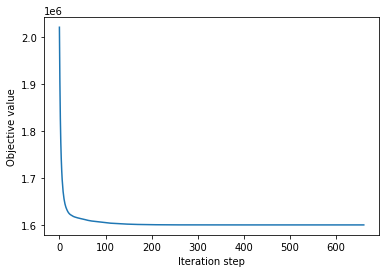

Figure(id='3581', ...)

In [36]:
def prox(w, alpha):
  phi = np.angle(w)
  return np.exp(phi*1j) * np.maximum(np.abs(w) - alpha, 0.)

# def prox(w, alpha):
#   # the alpha in equ(1.6) actually is the alpha*lambda in Lasso problem
#   # in practice, the alpha should be alpha*lambda = lambda / L
#   x = np.zeros(w.shape,dtype = np.complex128)
#   index = np.argwhere(np.abs(w) > alpha)
#   x[index] = w[index] * (np.abs(w[index])-alpha) / np.abs(w[index])
#   # for i in range(w.shape):
#   #   if(np.linalg.norm(w[i]) <= alpha):
#   #     x[i] = 0+0j
#   #   else:
#   #     x[i] = w[i] * (np.linalg.norm(w[i])-alpha) / np.linalg.norm(w[i])
#   return x

def proximal_gradient(Y, lamda, tolerance, maxstep):
  S = np.zeros(Y.shape, dtype = np.complex128)
  obj_value = []
  L = 1
  # initial iteration
  w = S + meas_map_adj(Y-meas_map(S))/L
  S = prox(w, lamda / L)
  obj = 0.5*np.linalg.norm(Y-meas_map(S), ord='fro') ** 2 + lamda * np.linalg.norm(S)
  obj_value.append(obj)
  # other iterations
  for i in range(1, maxstep):
    w = S + meas_map_adj(Y-meas_map(S))/L
    S = prox(w, lamda / L)
    obj = 0.5*np.linalg.norm(Y-meas_map(S), ord='fro') ** 2 + lamda * np.linalg.norm(S)
    obj_value.append(obj)
    if abs(obj - obj_value[i-1]) < tolerance:
      break
  return S, obj_value

lamda = 10
tolerance = 1e-4
maxstep = 900

x_recover, obj_value = proximal_gradient(Y, lamda, tolerance, maxstep)

import matplotlib.pyplot as plt
plt.plot(obj_value)
plt.xlabel('Iteration step')
plt.ylabel('Objective value')
plt.show()

result_recover = np.abs(idwt(levels, x_recover))
bpl.output_notebook()
imagesc(result_recover, title='Recovery Result, p={}'.format(p))



### Task 2: Assessing Performance

Complete the following performance evaluation tasks for your sparse recovery algorithm:
1. For at least 3 values of the Bernoulli parameter `p`, say `[0.1, 0.2, 0.4, 0.5, 0.7]`, perform at least 3 independent trials of the sparse recovery experiment. Here, "independent trials" means you should re-generate the measurement map in each separate experiment. For each experiment, calculate the mean squared error between your LASSO solver's output and the ground truth image `X` (make sure they are in the same domain!), and average the mean squared errors for each setting of `p` over the independent trials. Output a plot of these averaged mean squared errors as a function of `p`; include error bars corresponding to the trial variances.
2. How large do you need `p` to be before you get acceptable (in terms of both MSE and in terms of visual quality) results for the sparse recovery experiment? Can you give an explanation for why the performance may be worse here than in other experiments in terms of properties of the specific measurement map we use here?



**************************************MSE***************************************
p = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], MSE = 123.22312220839305


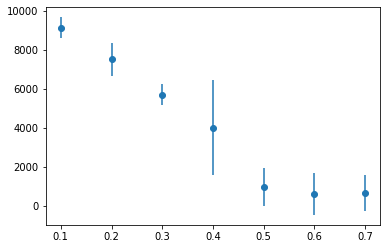



********************************Result Analysis*********************************
p needs to be greater than 0.5 
The measurement map we use here has worse MSE performance, and the variance is larger. So it may perform worse. 


In [38]:
# 1
print('\n')
print('MSE'.center(80,'*'))
MSE = np.square(np.subtract(result_recover,X)).mean()
print('p = {}, MSE = {}'.format(p, MSE))

# p = 0.1, MSE = 9596.270694000834
# p = 0.1, MSE = 9450.784897219555
# p = 0.1, MSE = 8383.574161797904
# p = 0.2, MSE = 7044.164352013616
# p = 0.2, MSE = 8729.815011743165
# p = 0.2, MSE = 6769.159295187644
# p = 0.3, MSE = 5144.450852252332
# p = 0.3, MSE = 6403.605826226221
# p = 0.3, MSE = 5580.194293451253
# p = 0.4, MSE = 570.7863108774419
# p = 0.4, MSE = 5865.857366057091
# p = 0.4, MSE = 5786.993432443082
# p = 0.4, MSE = 624.4543632188083
# p = 0.4, MSE = 5637.54615760526
# p = 0.4, MSE = 5615.941579942488
# p = 0.5, MSE = 261.136231808177
# p = 0.5, MSE = 211.21403653465805
# p = 0.5, MSE = 261.54034896752626
# p = 0.5, MSE = 1516.935826204762
# p = 0.5, MSE = 2669.5959693556206
# p = 0.6, MSE = 122.69761407548272
# p = 0.6, MSE = 119.84399633053259
# p = 0.6, MSE = 121.49804961053606
# p = 0.6, MSE = 121.81572300695858
# p = 0.6, MSE = 2977.836660718657
# p = 0.6, MSE = 123.22312220839305
# p = 0.7, MSE = 81.5966094114546
# p = 0.7, MSE = 73.23105639972964
# p = 0.7, MSE = 2471.424983530807
# p = 0.7, MSE = 76.96601782461126
# p = 0.7, MSE = 1205.281423995944
# p = 0.7, MSE = 79.9767642666164

p = [i/10 for i in range(1,8)]
MSE_1 = [9596.270694000834, 9450.784897219555, 8383.574161797904]
MSE_2 = [7044.164352013616, 8729.815011743165, 6769.159295187644]
MSE_3 = [5144.450852252332, 6403.605826226221, 5580.194293451253]
MSE_4 = [570.7863108774419, 5865.857366057091, 5786.993432443082, 624.4543632188083, 5637.54615760526, 5615.941579942488]
MSE_5 = [261.136231808177, 211.21403653465805, 261.54034896752626, 1516.935826204762, 2669.5959693556206]
MSE_6 = [122.69761407548272, 119.84399633053259, 121.49804961053606, 121.81572300695858, 2977.836660718657, 123.22312220839305]
MSE_7 = [81.5966094114546, 73.23105639972964, 2471.424983530807, 76.96601782461126, 1205.281423995944, 79.9767642666164]

plt.errorbar(p, [np.mean(MSE_1), np.mean(MSE_2), np.mean(MSE_3), np.mean(MSE_4), np.mean(MSE_5), np.mean(MSE_6), np.mean(MSE_7)], yerr=[np.std(MSE_1), np.std(MSE_2), np.std(MSE_3), np.std(MSE_4), np.std(MSE_5), np.std(MSE_6), np.std(MSE_7)], fmt="o")
plt.show()

# 2
print('\n')
print('Result Analysis'.center(80,'*'))
print('p needs to be greater than 0.5 \nThe measurement map we use here has worse MSE performance, and the variance is larger. So it may perform worse. ')

